Jumlah item loss pada Heuristic: 3107
Jumlah item loss pada Naive: 10309
Jumlah item loss pada Jaro_winkler: 0


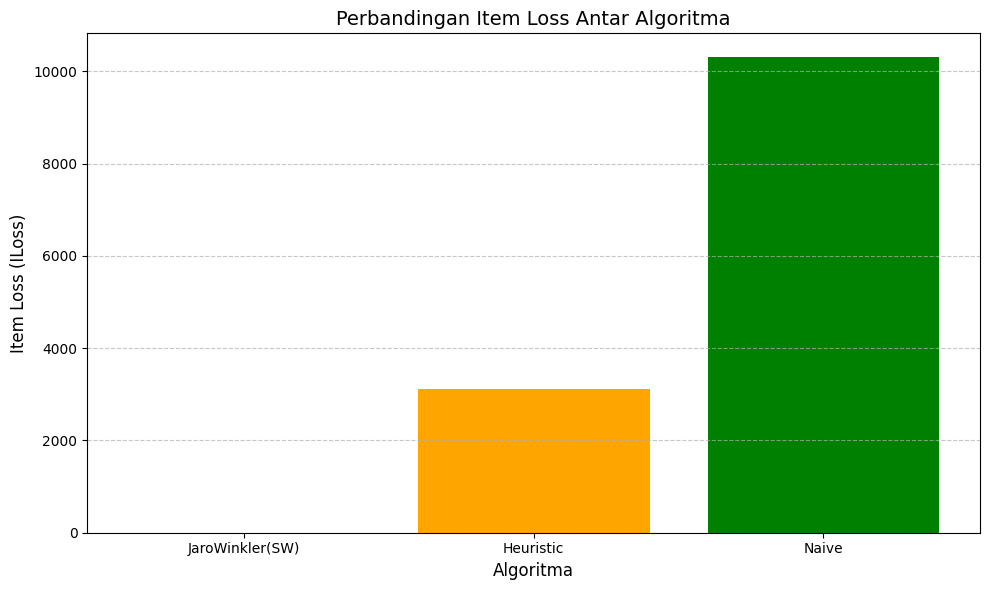

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

file_paths = {
    "original": "transaction.txt",
    "JaroWinkler(SW)": "jw_transaction.txt",
    "Heuristic": "heuristic_transaction2.txt",
    "Naive": "Naive_transaction2.txt",
}

def load_and_count(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if not lines:
            raise ValueError(f"File {file_path} is empty or invalid.")
        items = [int(item) for line in lines for item in line.strip().split()]
        return pd.Series(items).value_counts()
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found. Check the path.")
    except ValueError as ve:
        raise ValueError(f"Error processing file {file_path}: {ve}")

frequencies = {}
for key, path in file_paths.items():
    try:
        frequencies[key] = load_and_count(path)
    except Exception as e:
        print(e)

all_items = set().union(*[freq.index for freq in frequencies.values()])
aligned_frequencies = {
    key: freq.reindex(all_items, fill_value=0) for key, freq in frequencies.items()
}

# Corrected min_supp_range to be a tuple
min_supp_range = (0.003, 0.01)
feature_subset_ratio = 0.5

total_transactions = aligned_frequencies["original"].sum()

# Calculate min_supp_values using the correct range
min_supp_values = (
    total_transactions * min_supp_range[0],
    total_transactions * min_supp_range[1],
)

filtered_frequencies = {
    key: freq[(freq >= min_supp_values[0]) & (freq <= min_supp_values[1])]
    for key, freq in aligned_frequencies.items()
}

total_features = len(filtered_frequencies["original"])
subset_size = int(total_features * feature_subset_ratio)
selected_features = filtered_frequencies["original"].nlargest(subset_size).index

subset_frequencies = {
    key: freq.reindex(selected_features, fill_value=0)
    for key, freq in filtered_frequencies.items()
}

item_loss = {
    key: abs(subset_frequencies["original"].sum() - freq.sum())
    for key, freq in subset_frequencies.items() if key != "original"
}

print("Jumlah item loss pada Heuristic:", item_loss.get("Heuristic", "Data tidak tersedia"))
print("Jumlah item loss pada Naive:", item_loss.get("Naive", "Data tidak tersedia"))
print("Jumlah item loss pada Jaro_winkler:", item_loss.get("JaroWinkler(SW)", "Data tidak tersedia"))

plt.figure(figsize=(10, 6))
plt.bar(item_loss.keys(), item_loss.values(), color=['blue', 'orange', 'green'])
plt.title('Perbandingan Item Loss Antar Algoritma', fontsize=14)
plt.xlabel('Algoritma', fontsize=12)
plt.ylabel('Item Loss (ILoss)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()